<a href="https://colab.research.google.com/gist/oserikov/f430e81939ffff48cafd6377b9e67b9c/.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание о векторизации текстов

В задании вам предстоит сравнить несколько методов снижения размерности
* PCA
* t-SNE

а так же попробовать осуществить тематическое моделирование методом LDA.

**Формат сдачи задания** -- указание в гуглформе ссылки на тетрадь с решением + ответ на вопросы (см. последние вопросы первой задачи) в форме. Форма появится ближе к дедлайну.

**Дедлайн** 23.59 7 октября MSK.  

ДЗ предполагает возможность получения **до 12 баллов** по десятибалльной шкале. Оценки 11 и 12 поступают в ведомость, как оценки 11 и 12.

---

Если вы уже хорошо знакомы с снижением размерности, реализуйте первую задачу, используя не Bag-of-Words векторы текстов, а эмбеддинги текстов, полученные алгоритмом на ваш выбор. 
**Если вы собираетесь решать задачу так, то, приступая, сообщите об этом @oserikov в телеграме.**

Если вы уже хорошо знакомы ещё и с векторизацией текстов эмбеддингами, напишите @oserikov для обсуждения замены первой задачи на другую.


# [6 баллов] Задача о снижении размерности




[Вот](https://drive.google.com/drive/folders/1HX5rz4UZHtbzhPguUFolOg-xm6HFc0KO?usp=sharing) корпус, однажды собранный без особенных размышлений.
Это -- корпус любительской литературы. Он был собран для забавы и непонятно, какая природа у представленных там текстов.

Вам предстоит оценить, насколько эти тексты интересны в качестве простого датасета для задачи классификации: информативны ли Bag-of-Words векторы в смысле разделения текстов по жанрам.

---

### Постановка задачи

**Задача**: взяв фанифики и два каких-то других жанра из корпуса, визуализировать их BoW-представления на плоскости.

---

Визуализацию стоит осуществлять scatter-плотом, информацию о принадлежности документа какому-то жанру стоит передавать цветом.

Количество документов, представляющих каждый жанр, стоит подобрать семплированием нужного количества элементов под доступные вычислительные ресурсы -- полный корпус точно слишком велик.

Гиперпараметры BoW-векторизатора стоит подобрать под доступные вычислительные ресурсы -- если код работает дольше часа, то стоит упростить вычислительную задачу: подобрать другие гиперпараметры векторизации или уменьшить выборку.

#### Критерии


* **1 БАЛЛ**: 
  * В выбранных документах осуществлена какая-то **стандартная предобработка текста**: удалены стоп-слова и мусорные токены (e.g. html-теги), проведена лемматизация.  
  Решение о каждой конкретной детали предобработки остаётся на усмотрение студентов: каждое нестандартное действие (e.g. отказ от лемматизации или удаление каких-то особенных токенов) стоит пояснить коротким комментарием, описывающим мотивацию.
  * Получены **Bag-of-Words векторы** документов, выбранных для исследования. 
* **1 БАЛЛ**: получена визуализация документов на плоскости **методом главных компонент** снижения размерности Bag-of-Words векторов.
* **1 БАЛЛ**: получена визуализация документов на плоскости методом **t-SNE** снижения размерности Bag-of-Words векторов.
* **1 БАЛЛ**: на полученных визуализациях **получилось передать цветом точек классы** документов; понятно, точка какого цвета относится к какому классу.


Скорее всего визуализация t-SNE и PCA заметно отличаются раскладкой точек по плоскости: один метод как будто раскладывает их вдоль двух пересекающихся прямых, за другим такого свойства скорее всего нет. Ответ на два вопроса ниже вам предстоит указать в гуглформе, сдавая задание.
* **1 БАЛЛ**: верно указано, какой метод укладывает точки примерно вдоль прямых, а какой -- нет
* **1 БАЛЛ**: предложено верное описание тому, почему у одного из методов всегда результаты располагаются вдоль некоторых прямых. 



#### Примеры кода

Использование t-SNE и PCA для визуализации векторов: [ссылка](https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans).





### Начало решения

Загружу список стопслов и единожды инициализирую майстем для препроцессинга и лемматизации

In [45]:
import os
import re
import pandas as pd

from pymystem3 import Mystem
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")
m = Mystem()

In [46]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^а-яё]', ' ', text)
    text = [token for token in text.split() if token not in russian_stopwords]
    text = ' '.join(text)
    lemmas = m.lemmatize(text)
    text = " ".join(lemmas)
    return text

Загружу тексты в датафрейм, чтобы с ними было удобнее работать и потом воспроизводить мой код. 

Я выбрала жанры Хоррор, Фанфик и Публицистика. 

Думаю, их должно быть легко отличить.

Опытным путём я выяснила, что 50 текстов от каждого жанра оптимально по времени обработки.

In [47]:
def find_files(data_folder):
    n = 0
    files_paths = []
    for root, dirs, files in os.walk(data_folder):
        for name in files:
            path = os.path.join(root, name)
            if name.endswith('.txt'):
                files_paths.append(path)
                n += 1
                if n == 50:
                    return files_paths

In [48]:
def construct_df(files_paths):
    columns = ['text', 'genre']
    df_name = pd.DataFrame(columns = columns)
    for file in files_paths:
        with open(file, 'r', encoding='utf-8') as f:
            text = f.read()
        genre = file.split('/')[0]
        df_single_file = pd.DataFrame({'text': [text], 'genre': [genre]})
        df_name = pd.concat([df_name, df_single_file], axis=0)
    return df_name

In [49]:
genres = ['Хоррор', 'Фанфик', 'Публицистика']

In [50]:
%%time

columns = ['text', 'genre']
texts_df = pd.DataFrame(columns = columns)
for genre in genres:
    files_paths = find_files(genre)
    genre_df = construct_df(files_paths)
    texts_df = pd.concat([texts_df, genre_df], axis=0)

CPU times: user 480 ms, sys: 80 ms, total: 560 ms
Wall time: 725 ms


In [52]:
texts_df.head(2)

,text,genre
0,\n\n\nИзначально идея этого произведения (точн...,Хоррор
0,\n\n\nСередина лета. Выцветшее светло-голубое ...,Хоррор


Сохраню датафрейм со всеми текстами.

In [53]:
texts_df.to_csv('corpus250.csv', header=True, index=False)

Добавлю для каждого текста его предобработанный вариант в датафрейм

In [54]:
%%time
texts_df['clean_text'] = texts_df.text.apply(lambda x: str(preprocess(x)))

CPU times: user 59.2 s, sys: 6.18 s, total: 1min 5s
Wall time: 2min 13s


Инициализириую векторайзер. Я выбрала Tf-Idf, чтобы снизить влияние частотных слов, которые не являются стоп словами.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000)

In [57]:
%%time
corpus_vectors = vectorizer.fit_transform(texts_df['clean_text'].tolist())

CPU times: user 1.26 s, sys: 37.2 ms, total: 1.29 s
Wall time: 1.32 s


## PCA

Построю график.
Для построения графика использую [код из источника](https://coderoad.ru/54939424/Построение-векторных-текстовых-документов-в-matplotlib)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [77]:
genre2label = {'Хоррор': 0, 'Фанфик': 1, 'Публицистика': 2}
label2genre = {0: 'Хоррор', 1: 'Фанфик', 2: 'Публицистика'}
clusters = [genre2label[x] for x in texts_df['genre'].tolist()]

In [70]:
pca = PCA(n_components=2)
two_dim = pca.fit_transform(corpus_vectors.todense())
scatter_x = two_dim[:, 0] 
scatter_y = two_dim[:, 1]

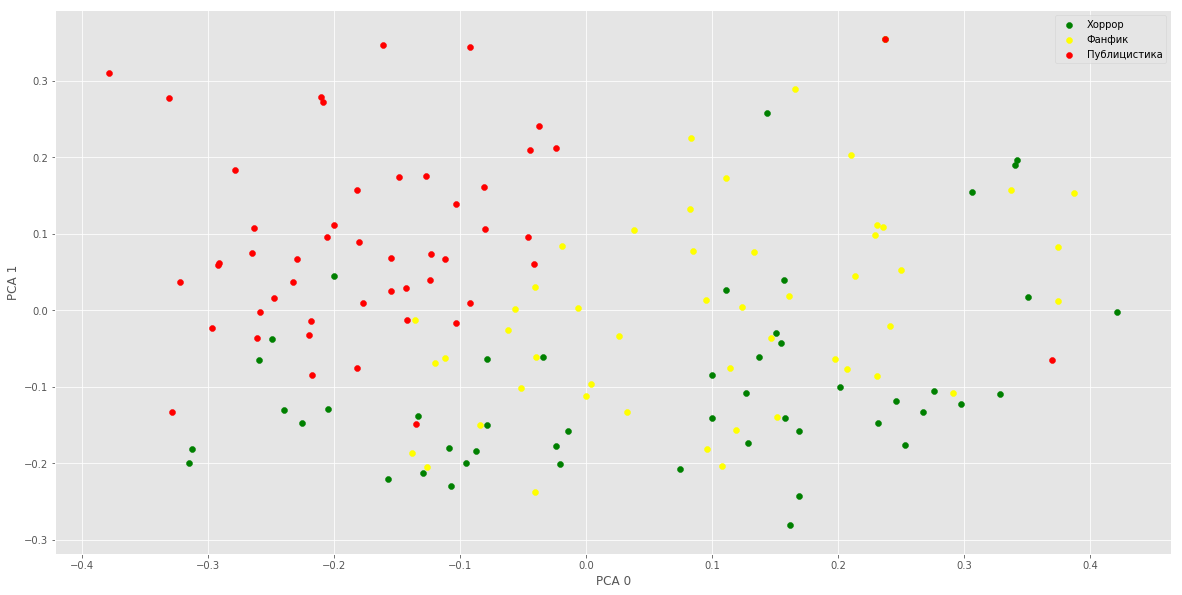

In [78]:
plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

cmap = {0: 'green', 1: 'yellow', 2: 'red'}
for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=label2genre[group])
    
ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

## t-SNE

Для построения графика использую [код из источника](https://towardsdatascience.com/t-sne-python-example-1ded9953f26)

In [83]:
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 3)

In [84]:
tsne = TSNE()
X_embedded = tsne.fit_transform(corpus_vectors.todense())

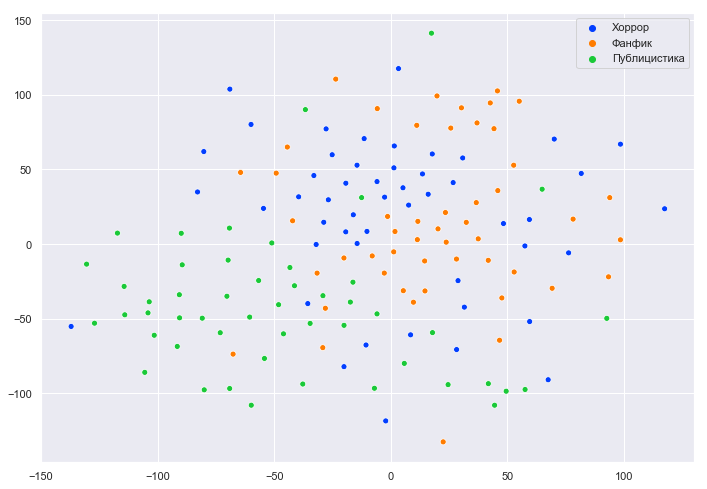

In [86]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=texts_df['genre'].tolist(), legend='full', palette=palette)

## [6 баллов] Задача о тематическом моделировании



### об LDA




### Постановка задачи
Загрузите [коллекцию писем Х. Клинтон](https://www.kaggle.com/kaggle/hillary-clinton-emails/?select=Emails.csv) с kaggle. Для скачивания может потребоваться регистрация.

Методом LDA выделите несколько тем в переписке Х. Клинтон, дайте им словесное описание. Используйте библиотеку LdaModel из gensim.

#### Критерии

* **2 БАЛЛА**: получены списки ключевых слов, не выглядящие бессмыслицей
* **2 БАЛЛА**: осуществлена визуализация библиотекой pyLDAvis
* **1 БАЛЛ**: предложено осмысленное текстовое описание большинства выделенных тем.
* **1 БАЛЛ**: проведено сравнение LDA, запущенного на CountVectorizer и TfIdfVectorizer предтавлениях одних и тех же данных. 

#### примеры кода

Пример обучения LdaModel на выдаче CountVectorizer: [ссылка](https://github.com/EricSchles/sklearn_gensim_example/blob/master/example.py)

Пример использования pyLDAvis: секция 15 [по ссылке](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

---

Для обучения *LdaModel* и её последующей визуализации потребуется словарь формата gensim. Словарь формата gensim удобно получать из сжатого csc_matrix-представления нашего векторизованного текста: как многие замечали на паре, tf-idf векторы содержат много нулей.

```python
import gensim
from scipy.sparse import csc

corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, vocab_dict)
```

где *corpora* содержит полученное с помощью gensim представление коллекции, а *vocab_dict* — это dict, полученный после работы Vectorizer, ставящий в соответствие каждому номеру строки в матрице данных само слово в виде строки.

### Начало решения

Загружу емейлы в датафремы, оставлю только сырой текст

In [93]:
emails = pd.read_csv('Emails.csv')

In [96]:
emails_texts = emails[['RawText']]

In [210]:
emails_texts.head(2)

,RawText,clean_text
0,UNCLASSIFIED\nU.S. Department of State\nCase N...,wonderful strong move statement boss sen mccai...
1,UNCLASSIFIED\nU.S. Department of State\nCase N...,hrc memo syria aid libya docx hrc memo syria a...


В сырых текстах много мусора, а в колонке с уже выделенным текстом значения как-то не ок. Попробую написать простой парсер, чтобы извлекать текст. 

#### Мой препроцессинг основан на этих предположениях:
- препроцессинг влияет на качество LDA
- строка осмысленного текста содержит более 10 токенов, т е я не учитываю сообщения вроде ```print this pls```
- в строке осмысленного текста > 80% знаков строчные
- в одинаковых строках в развернутых цепочках абсолютно одинаковое всё и их можно так найти и удалить
- выкидывать все небуквенные знаки это ок
- лемматизация полезна
- удалять стопслова полезно и стоит использовать их расширенный список с [Towards NLP](https://t.me/towards_nlp)
- убирать капитализацию не вредно

In [98]:
import re

In [113]:
import pattern
from pattern.en import lemma, lexeme

In [127]:
with open('extended_stopwords_towards_nlp.txt', 'r', encoding='utf-8') as file:
    raw = file.read()
stopwords = raw.split()

In [161]:
def check_cap_ratio(line):
    is_ratio_ok = False
    n_upper = 0
    for character in line:
        if character.isupper():
            n_upper += 1
    capitalized_ratio = n_upper / len(line)
    if capitalized_ratio < 0.20:
        is_ratio_ok = True
    return is_ratio_ok
            

def preprocess_raw(raw_text):
    lines = raw_text.split('\n')
    unique_lines = []
    lemmas = []
    for line in lines:
        if len(line.split()) > 10:
            if line not in unique_lines:
                unique_lines.append(line)
                is_capitalized_ratio_ok = check_cap_ratio(line)
                if is_capitalized_ratio_ok:
                    clean_text = re.sub("[^A-Za-z']", ' ', line)
                    line_lemmas = [lemma(wd) for wd in clean_text.split() if lemma(wd) not in stopwords]
                    lemmas.extend(line_lemmas)
    preproc_text = ' '.join(lemmas)
    return preproc_text
                
    

Посмотрю как препроцессинг работает на нескольких строках. ```a, b, c``` - строки осмысленного текста, а ```d, e, f``` названия файлов.

In [162]:
a = 'Fighting Group (LIFG), some of whom are loyal to Islamist General Abdelhakirn Belhaj. The same'
b = 'SOURCE: Sources with direct access to the Libyan National Transitional Council, as well as the'
c = "they are concerned that the death of al Qa'ida leader Osama Bin Laden"
d = 'STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.'
e = 'Case No. F-2015-04841'
f = 'UNCLASSIFIED U.S. Department of State Case No. F-2014-20439 Doc No. C05778470 Date: 08/31/2015'
tests = [a, b, c, d, e, f]

In [163]:
for i in tests:
    print(preprocess_raw(i))

fight group lifg loyal islamist general abdelhakirn belhaj
source source direct access libyan national transitional council well
concern death al qa'ida leader osama bin lade





In [164]:
%%time
emails_texts['clean_text'] = emails_texts.RawText.apply(lambda x: str(preprocess_raw(x)))

CPU times: user 20.2 s, sys: 119 ms, total: 20.3 s
Wall time: 20.8 s


/Users/elizavetaersova/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [169]:
emails_texts.head(5)

,RawText,clean_text
0,UNCLASSIFIED\nU.S. Department of State\nCase N...,wonderful strong move statement boss sen mccai...
1,UNCLASSIFIED\nU.S. Department of State\nCase N...,hrc memo syria aid libya docx hrc memo syria a...
2,UNCLASSIFIED\nU.S. Department of State\nCase N...,colleague i'm terribly fso stand front surely ...
3,UNCLASSIFIED\nU.S. Department of State\nCase N...,spokesperson bureau eastern affair department...
4,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,fw latest syria aid qaddafi sid subject latest...


Ура! Препроцессинг работает быстро и первые токены в столбце ```clean_text``` выглядят ок

## LDA c Tfidf

In [171]:
import numpy as np

from gensim import matutils
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer

In [233]:
tfidf_vectorizer = TfidfVectorizer(
    min_df = 0.0001,
    max_df = 0.95,
    max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(emails_texts.clean_text)
vocab_tfidf = tfidf_vectorizer.get_feature_names()

In [208]:
def fit_lda(X, vocab, num_topics=5, passes=20):
    """ Fit LDA from a scipy CSR matrix (X). """
    print('fitting lda...')
    return LdaModel(matutils.Sparse2Corpus(X.T), num_topics=num_topics,
                    passes=passes,
                    id2word=dict([(i, s) for i, s in enumerate(vocab)]))


def print_topics(lda, vocab, n=10):
    """ Print the top words for each topic. """
    topics = lda.print_topics(num_topics=-1, num_words=n)
    for topic in topics:
        print(topic)
        print()

In [234]:
%%time
lda_tfidf = fit_lda(X_tfidf, vocab_tfidf, num_topics=25)

fitting lda...
CPU times: user 2min 29s, sys: 11.1 s, total: 2min 40s
Wall time: 1min 23s


In [214]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [235]:
import gensim
from scipy.sparse import csc

corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X_tfidf))
id2word = gensim.corpora.Dictionary.from_corpus(corpus, lda_tfidf.id2word)

In [239]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_tfidf, corpus, id2word)
vis

/Users/elizavetaersova/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.341404 -0.078598       1        1  24.263968
3      0.019067  0.261348       2        1  11.931901
6     -0.011910  0.241189       3        1   9.365978
22     0.058762  0.191839       4        1   8.475696
14    -0.335351  0.058538       5        1   6.986353
19     0.023253 -0.004972       6        1   4.238645
21     0.040314 -0.033607       7        1   3.345964
11     0.009079 -0.039581       8        1   2.486002
15     0.038827 -0.030315       9        1   2.257819
0      0.082156 -0.023445      10        1   2.245612
17    -0.017823 -0.026152      11        1   2.184159
20     0.076103 -0.037737      12        1   2.140008
13     0.028038 -0.040540      13        1   1.902235
7      0.077189 -0.032111      14        1   1.836638
23     0.047059 -0.045402      15        1   1.816080
9      0.071129 -0.036669      16        1   1.800532
1     -0.087198 -0.026664      17        1   1.768213
24     0.071519 -0.035459      18        1   1.655065
18    -0.157499 -0.040475      19        1   1.635249
5      0.070896 -0.033011      20        1   1.480351
12     0.070575 -0.038841      21        1   1.440212
2     -0.009832 -0.041261      22        1   1.225232
8      0.058955 -0.038422      23        1   1.212753
10     0.062769 -0.034494      24        1   1.208390
16     0.055328 -0.035157      25        1   1.096941, topic_info=     Category        Freq         Term       Total  loglift  logprob
1223  Default  150.000000         call  150.000000  30.0000  30.0000
9824  Default  173.000000         will  173.000000  29.0000  29.0000
6494  Default   52.000000  palestinian   52.000000  28.0000  28.0000
4700  Default   55.000000       israel   55.000000  27.0000  27.0000
9001  Default  154.000000          thi  154.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
4416  Topic25    0.787288  incorporate   10.499524   1.9222  -6.2846
1223  Topic25    1.978194         call  150.518860   0.1807  -5.3632
8859  Topic25    1.259522         talk   79.497902   0.3676  -5.8147
4204  Topic25    0.895301         hour   26.349102   1.1306  -6.1560
2788  Topic25    0.725899         edit   22.917393   1.0604  -6.3658

[1205 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5        11  0.897954     abba
18        2  0.209702   abedin
18       17  0.768908   abedin
28       15  0.831559    aboul
41        6  0.444996  abstain
...     ...       ...      ...
9970      9  0.779924       yu
9971      7  0.827310     yunu
9977      8  0.582818  zardari
9980     15  0.609180  zealand
9988      7  0.687070      zia

[2067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 7, 23, 15, 20, 22, 12, 16, 1, 18, 21, 14, 8, 24, 10, 2, 25, 19, 6, 13, 3, 9, 11, 17])

### Списки слов с комментариями

Я попробовала задать кол-во топиков равным 5, 10, 25, 50 и 100.

Больше всего мне понравилось разбиение при 25 топиках, ниже привожу наиболее понятные на мой взгляд списки ключевых слов.

Мои пояснения к ним основаны на опыте использования корпоративной почты и сериале Карточный домик.

Вывести все списки слов можно через ```print_topics(lda_tfidf, vocab_tfidf)```, в тетрадке оно смотрится не оч.


Топик про политику Соединенного Королевства:

```(0, '0.026*"cameron" + 0.022*"tory" + 0.017*"labour" + 0.017*"brown" + 0.015*"gordon" + 0.012*"mexican" + 0.008*"peter" + 0.007*"inr" + 0.006*"google" + 0.006*"david"')```

Топики про геополитику:

```((11, '0.017*"russian" + 0.015*"cloture" + 0.014*"conf" + 0.012*"raj" + 0.011*"vote" + 0.010*"reid" + 0.010*"lavrov" + 0.009*"leave" + 0.009*"turkish" + 0.009*"joanne"')```

```(21, '0.034*"palestinian" + 0.031*"israel" + 0.025*"netanyahu" + 0.021*"israeli" + 0.019*"haitian" + 0.018*"settlement" + 0.015*"gaza" + 0.013*"room" + 0.012*"prime" + 0.010*"conference"')```

```(24, '0.015*"kyrgyzstan" + 0.013*"chappaqua" + 0.012*"steve" + 0.012*"oprah" + 0.009*"valmoro" + 0.008*"convenience" + 0.008*"rch" + 0.007*"deserve" + 0.007*"straight" + 0.007*"onward"')```

Топики по организации звонков, и встреч:

```(1, '0.028*"jacob" + 0.026*"sullivan" + 0.022*"mill" + 0.019*"cheryl" + 0.016*"abedin" + 0.014*"huma" + 0.014*"steinberg" + 0.014*"cc" + 0.012*"jack" + 0.012*"call"')```

```(2, '0.019*"pi" + 0.019*"tonite" + 0.016*"thx" + 0.015*"dc" + 0.014*"call" + 0.014*"tomorrow" + 0.013*"cancel" + 0.013*"pl" + 0.011*"ny" + 0.011*"wh"')```

```(8, '0.023*"noon" + 0.022*"depart" + 0.018*"airport" + 0.014*"memcon" + 0.013*"pm" + 0.012*"floor" + 0.011*"denni" + 0.010*"en" + 0.010*"route" + 0.009*"washington"')```

```(14, '0.022*"call" + 0.017*"will" + 0.013*"tomorrow" + 0.012*"thi" + 0.011*"time" + 0.011*"work" + 0.010*"talk" + 0.010*"morn" + 0.009*"today" + 0.009*"send"')```

```(15, '0.022*"robinson" + 0.020*"tuesday" + 0.014*"dinner" + 0.011*"kurt" + 0.010*"mcguinnes" + 0.008*"rich" + 0.008*"norwegian" + 0.007*"korean" + 0.007*"fm" + 0.007*"korea"')```


Топики по делам конгресса - протолкнуть биль, порешать госдолг:

```(4, '0.011*"thi" + 0.009*"will" + 0.007*"state" + 0.005*"president" + 0.005*"work" + 0.005*"secretary" + 0.005*"government" + 0.004*"meet" + 0.004*"clinton" + 0.004*"year"')```

```(22, '0.011*"ap" + 0.010*"republican" + 0.009*"senate" + 0.007*"tax" + 0.005*"money" + 0.005*"award" + 0.005*"gate" + 0.005*"financial" + 0.004*"budget" + 0.004*"expo"')```

## LDA c CountVectorizer

In [221]:
from sklearn.feature_extraction.text import CountVectorizer

In [229]:
count_vectorizer = CountVectorizer(
    min_df = 0.0001,
    max_df = 0.95,
    max_features=10000)
X = count_vectorizer.fit_transform(emails_texts.clean_text)
vocab = count_vectorizer.get_feature_names()

In [224]:
%%time
lda_count_vec = fit_lda(X, vocab, num_topics=25)

fitting lda...
CPU times: user 4min 26s, sys: 19.8 s, total: 4min 46s
Wall time: 2min 38s


In [225]:
corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
id2word = gensim.corpora.Dictionary.from_corpus(corpus, lda_count_vec.id2word)

In [227]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_count_vec, corpus, id2word)
vis

/Users/elizavetaersova/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.021030  0.005914       1        1  13.423422
18    -0.173519  0.051885       2        1  10.604249
14    -0.068508  0.039487       3        1   8.163767
2     -0.146644  0.011361       4        1   6.991526
24    -0.011276 -0.059749       5        1   6.023098
15     0.057239  0.063032       6        1   5.470553
6     -0.086541  0.080052       7        1   4.547534
0     -0.081091 -0.015575       8        1   4.339839
11    -0.111251  0.000887       9        1   4.021642
13    -0.046672 -0.102580      10        1   3.924865
20    -0.054020 -0.061240      11        1   3.471759
3     -0.107360 -0.023747      12        1   3.197039
8     -0.041500  0.096525      13        1   3.130260
1     -0.125571 -0.103188      14        1   2.910091
22    -0.073114  0.198032      15        1   2.764181
4     -0.096622 -0.155938      16        1   2.738128
21     0.206150 -0.103587      17        1   2.184407
5      0.074126 -0.062270      18        1   2.126433
9      0.192933 -0.121459      19        1   1.834580
17     0.258256 -0.050188      20        1   1.626189
23     0.176598  0.079110      21        1   1.577739
12    -0.046325  0.103605      22        1   1.572780
16    -0.039496 -0.133604      23        1   1.428141
19     0.167406  0.125372      24        1   1.014958
10     0.155772  0.137863      25        1   0.912820, topic_info=     Category          Freq      Term         Total  loglift  logprob
9824  Default   7749.000000      will   7749.000000  30.0000  30.0000
9001  Default  10837.000000       thi  10837.000000  29.0000  29.0000
6233  Default   2114.000000     obama   2114.000000  28.0000  28.0000
1223  Default   2856.000000      call   2856.000000  27.0000  27.0000
6486  Default   1555.000000  pakistan   1555.000000  26.0000  26.0000
...       ...           ...       ...           ...      ...      ...
9752  Topic25     58.343235      week   1596.681396   1.3870  -4.8461
9059  Topic25     61.392963      time   3392.870361   0.6843  -4.7952
5616  Topic25     49.506004   meeting    379.430695   2.6598  -5.0104
9083  Topic25     51.858616     today   1508.759521   1.3259  -4.9639
5918  Topic25     50.296700      move    933.776855   1.7751  -4.9945

[1739 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         1  0.161262       abba
5        18  0.831122       abba
9        12  0.975164      abdel
13        6  0.985388  abduction
15        4  0.043537   abdullah
...     ...       ...        ...
9996      4  0.323619       zone
9996      8  0.069972       zone
9996     13  0.553943       zone
9996     16  0.032070       zone
9996     22  0.017493       zone

[6057 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 19, 15, 3, 25, 16, 7, 1, 12, 14, 21, 4, 9, 2, 23, 5, 22, 6, 10, 18, 24, 13, 17, 20, 11])

### Списки слов с комментариями

Топики по геополитике:

```(16, '0.043*"israel" + 0.029*"israeli" + 0.026*"palestinian" + 0.022*"will" + 0.020*"peace" + 0.016*"party" + 0.014*"netanyahu" + 0.013*"state" + 0.013*"arab" + 0.012*"settlement"')```

```(0, '0.039*"pakistan" + 0.024*"clinton" + 0.018*"state" + 0.017*"pakistani" + 0.016*"american" + 0.015*"country" + 0.013*"unite" + 0.010*"africa" + 0.010*"india" + 0.009*"secretary"')```

```(4, '0.021*"iran" + 0.019*"nuclear" + 0.017*"vote" + 0.017*"senate" + 0.015*"bill" + 0.011*"house" + 0.010*"russia" + 0.010*"north" + 0.009*"committee" + 0.009*"obama"')```

Топики по организации звонков, и встреч:

```(9, '0.033*"will" + 0.031*"call" + 0.027*"agree" + 0.027*"shaun" + 0.019*"eu" + 0.015*"hrc" + 0.015*"turkey" + 0.012*"agreement" + 0.012*"robinson" + 0.010*"martin"')```


Топики по президентским делам - текущий президент, предвыборная кампания:

```(1, '0.053*"obama" + 0.029*"president" + 0.026*"republican" + 0.019*"house" + 0.014*"party" + 0.014*"white" + 0.013*"administration" + 0.012*"democrat" + 0.011*"election" + 0.010*"campaign"')```

```(14, '0.014*"women" + 0.014*"state" + 0.012*"public" + 0.012*"work" + 0.011*"department" + 0.010*"will" + 0.010*"thi" + 0.009*"diplomacy" + 0.007*"service" + 0.006*"year"')```

Топик про политику Соединенного Королевства:

```((13, '0.022*"will" + 0.014*"brown" + 0.013*"tory" + 0.012*"party" + 0.012*"cameron" + 0.011*"uk" + 0.011*"thi" + 0.010*"labour" + 0.010*"gordon" + 0.009*"blair"')```

Связи с общественностью:

```(5, '0.051*"subject" + 0.028*"fw" + 0.025*"pm" + 0.022*"reuter" + 0.022*"secretary" + 0.018*"minister" + 0.017*"ap" + 0.017*"official" + 0.013*"state" + 0.012*"visit"')```

```(22, '0.045*"company" + 0.016*"corporate" + 0.013*"david" + 0.013*"busines" + 0.011*"bloomberg" + 0.010*"center" + 0.010*"spend" + 0.009*"industry" + 0.009*"dollar" + 0.009*"foreign"')```

## Сравнение

Оба векторайзера одинаково выделили самую большую тему - президентскую кампанию Клинтон.
Кластеры тем у них тоже похожи: про внешнюю политику, организация, дела внутри конгресса.
Tfidf почему-то сваливает в кучу много не очень похожих топиков, у CountVectorizer выделение топиков происходит более сбалансированно.